In [1]:
!pip install crowd-kit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from crowdkit.aggregation import DawidSkene, MajorityVote

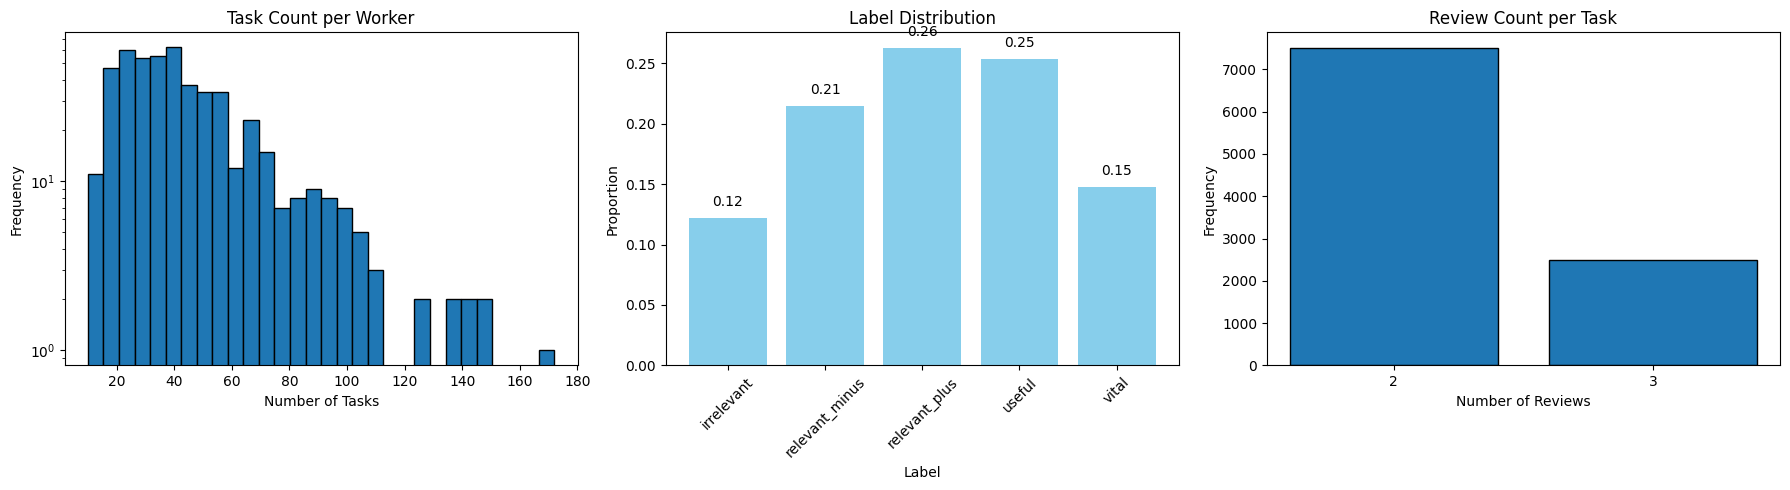


Most Significant Disagreement Cases:

Task 3879 (Credibility Difference: 0.49)
Labels assigned: ['relevant_minus' 'vital']
Worker credibilities: [0.99310537 0.50253079]
MajorityVote: relevant_minus, DawidSkene: vital

Task 641 (Credibility Difference: 0.49)
Labels assigned: ['useful' 'relevant_plus' 'useful']
Worker credibilities: [0.50541883 0.99344347 0.59935784]
MajorityVote: useful, DawidSkene: relevant_plus

Task 866 (Credibility Difference: 0.49)
Labels assigned: ['relevant_minus' 'useful' 'relevant_plus']
Worker credibilities: [0.50829391 0.99525257 0.98792604]
MajorityVote: relevant_minus, DawidSkene: useful

Task 7947 (Credibility Difference: 0.49)
Labels assigned: ['useful' 'irrelevant']
Worker credibilities: [0.99502693 0.50829391]
MajorityVote: irrelevant, DawidSkene: relevant_minus

Task 1230 (Credibility Difference: 0.48)
Labels assigned: ['vital' 'relevant_plus' 'useful']
Worker credibilities: [0.9871974  0.50276106 0.85312111]
MajorityVote: relevant_plus, DawidSkene: v

In [3]:
np.random.seed(42)

# Dataset Generation
number_tasks = 10000
number_workers = 500

# labels
labels = ['irrelevant',  'relevant_minus', 'relevant_plus', 'useful', 'vital']
label_distribution = [0.1, 0.2, 0.3, 0.3, 0.1]

# Task coverage settings
overlap_3_ratio = 0.25
overlap_2_ratio = 0.75

worker_credibility = np.random.rand(number_workers) * 0.5 + 0.5

# log-normal distribution
worker_task_counts = np.random.lognormal(3, 0.5, number_workers)
worker_task_counts = np.clip(worker_task_counts, 5, 100).astype(int)

def generate_tasks(
    number_tasks: int,
    overlap: list[int],
    labels: list[str],
    label_distribution: list[float],
    worker_credibility: np.ndarray,
    worker_task_counts: np.ndarray
) -> pd.DataFrame:
    tasks = []
    workers = []
    labels_assigned = []

    available_task_counts = worker_task_counts.copy()

    for task_id in range(number_tasks):
        num_assessors = overlap[task_id]

        # Find workers who can still take on more tasks
        available_workers = np.where(available_task_counts > 0)[0]

        # If not enough available workers, reset available_task_counts
        if len(available_workers) < num_assessors:
            available_task_counts = worker_task_counts.copy()
            available_workers = np.where(available_task_counts > 0)[0]

        # Select workers
        assigned_workers = np.random.choice(
            available_workers,
            size=num_assessors,
            replace=False
        )

        available_task_counts[assigned_workers] -= 1

        # Generate base label with realistic disagreement
        if np.random.rand() < 0.7:
            main_label_idx = np.random.choice(len(labels), p=label_distribution)
            possible_labels = labels[max(0, main_label_idx-1):min(len(labels), main_label_idx+2)]
            task_labels = np.random.choice(possible_labels, num_assessors)
        else:
            task_labels = np.random.choice(labels, num_assessors, p=label_distribution)

        for i, worker in enumerate(assigned_workers):
            tasks.append(task_id)
            workers.append(worker)

            if worker_credibility[worker] > 0.8:
                labels_assigned.append(task_labels[i])
            else:
                current_label_idx = labels.index(task_labels[i])
                noise_range = max(0, current_label_idx-1), min(len(labels)-1, current_label_idx+1)
                labels_assigned.append(labels[np.random.randint(noise_range[0], noise_range[1]+1)])

    return pd.DataFrame({
        'task': tasks,
        'worker': workers,
        'label': labels_assigned
    })

# Generate data with adjusted overlap ratios
overlap = [3] * int(number_tasks * overlap_3_ratio) + [2] * int(number_tasks * overlap_2_ratio)
data = generate_tasks(number_tasks, overlap, labels, label_distribution, worker_credibility, worker_task_counts)

def visualize_distributions(data: pd.DataFrame) -> None:
    task_count_per_worker = data['worker'].value_counts()
    label_distribution_actual = data['label'].value_counts(normalize=True)
    task_overlap_distribution = data['task'].value_counts()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Distribution of tasks per worker
    axes[0].hist(task_count_per_worker, bins=30, edgecolor='black')
    axes[0].set_title('Task Count per Worker')
    axes[0].set_xlabel('Number of Tasks')
    axes[0].set_ylabel('Frequency')
    axes[0].set_yscale('log')

    # Label distribution
    label_distribution_ordered = label_distribution_actual.reindex(labels)
    axes[1].bar(range(len(label_distribution_ordered)), label_distribution_ordered.values, color='skyblue')
    axes[1].set_xticks(range(len(label_distribution_ordered)))
    axes[1].set_xticklabels(label_distribution_ordered.index, rotation=45)
    axes[1].set_title('Label Distribution')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Proportion')
    for i, v in enumerate(label_distribution_ordered.values):
        axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center')

    # Distribution of review counts per task
    axes[2].bar(range(2, 4),
               [sum(task_overlap_distribution == i) for i in range(2, 4)],
               edgecolor='black')
    axes[2].set_title('Review Count per Task')
    axes[2].set_xlabel('Number of Reviews')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xticks([2, 3])

    plt.tight_layout()
    plt.show()

def aggregate_labels(data: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    mv = MajorityVote()
    ds = DawidSkene()
    mv_result = mv.fit_predict(data)
    ds_result = ds.fit_predict(data)
    return mv_result, ds_result

# Perform aggregation and analysis
mv_result, ds_result = aggregate_labels(data)
results = pd.DataFrame({
    'task': data['task'].unique(),
    'MajorityVote': mv_result.values,
    'DawidSkene': ds_result.values
}).reset_index(drop=True)

# Find significant disagreements
disagreements = results[results['MajorityVote'] != results['DawidSkene']]

def analyze_significant_cases(disagreements: pd.DataFrame, data: pd.DataFrame, worker_credibility: np.ndarray, n_cases: int = 5) -> None:
    significant_cases = []

    for i, row in disagreements.iterrows():
        task_id = row['task']
        task_data = data[data['task'] == task_id]
        workers = task_data['worker'].values
        cred_diff = max(worker_credibility[workers]) - min(worker_credibility[workers])

        significant_cases.append((task_id, cred_diff, task_data, row['MajorityVote'], row['DawidSkene']))

    # Sort by credibility difference and take cases
    significant_cases.sort(key=lambda x: x[1], reverse=True)

    print("\nMost Significant Disagreement Cases:")
    for task_id, cred_diff, task_data, mv_label, ds_label in significant_cases[:n_cases]:
        print(f"\nTask {task_id} (Credibility Difference: {cred_diff:.2f})")
        print(f"Labels assigned: {task_data['label'].values}")
        print(f"Worker credibilities: {worker_credibility[task_data['worker'].values]}")
        print(f"MajorityVote: {mv_label}, DawidSkene: {ds_label}")

# Display distributions and analyze significant cases
visualize_distributions(data)
analyze_significant_cases(disagreements, data, worker_credibility)